# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN.
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [3]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN

## Create random data to pass through the SimpleNN architecture
random_data = torch.randn(1,3,32,32)
## Create an example network to test on
test_network = SimpleNN()
## Feed the sample data into the network to get test result
test_out = test_network(random_data)
## Check to make sure that the output has shape 1x10
assert(test_out.detach().cpu().numpy().shape == (1,10))
print("Forward pass successful")

## Count the number of parameters in each layer
for name, parameters in test_network.named_parameters():
  ## Print the shape of the parameter vector for each layer
  print(f'{name:10}: {str(parameters.shape):10}')
#############################################

Forward pass successful
conv1.weight: torch.Size([8, 3, 5, 5])
conv1.bias: torch.Size([8])
conv2.weight: torch.Size([16, 8, 3, 3])
conv2.bias: torch.Size([16])
fc1.weight: torch.Size([120, 576])
fc1.bias  : torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias  : torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias  : torch.Size([10])


> Here, I used one batch of random data in the format of 3 layers (RBG) each having 32x32 pixels to pass through the constructed SimpleNN structure. To verify that the pass was successful, I checked to make sure that the output has is in shape 1x10.
>
> And to verify the structure of the layers, I checked the shape of the parameters in the network to make sure they align with my expectations of what was inputted in the SimpleNN structure.

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint:
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [4]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomCrop(size = 32, padding = 4),
    transforms.RandomHorizontalFlip()]
    )
transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )
#############################################

> In this operation I used random to crop out 7 pixels from the center and then random horizontal flips with a probability of 0.5.

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [5]:
# Unzip the tools zipfile
# !unzip tools.zip

In [5]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [6]:
# specify the device for computation
#############################################
# your code here

# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

model = SimpleNN()
model = model.to(device)
#############################################

Run on GPU...


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [7]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr = INITIAL_LR, momentum = MOMENTUM, weight_decay = REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps:

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


# Bonus: with learning rate decay

The following code can help you adjust the learning rate during training. You need to figure out how to incorporate this code into your training loop.
```python
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
```

In [8]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

## Set the number of epochs the decay parameter kicks in each time
DECAY_EPOCHS = 5
## Set the scaler for the decay
DECAY = 0.8

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    # if i % DECAY_EPOCHS == 0 and i != 0:
    #     current_learning_rate = current_learning_rate * DECAY
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = current_learning_rate
    #     print("Current learning rate has decayed to %f" %current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    model.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = TRAIN_BATCH_SIZE
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        output = model(inputs)
        loss = criterion(output, targets)
        train_loss += loss

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        predicted = torch.argmax(output, 1)
        correct_examples += (predicted == targets).sum().item()
        total_examples += inputs.shape[0]
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = VAL_BATCH_SIZE
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            output = model(inputs)
            loss = criterion(output, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            predicted = torch.argmax(output, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += inputs.shape[0]
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.9377, Training accuracy: 0.2759
Validation loss: 1.5835, Validation accuracy: 0.4071
Saving ...

Epoch 1:
Training loss: 1.5775, Training accuracy: 0.4190
Validation loss: 1.4571, Validation accuracy: 0.4549
Saving ...

Epoch 2:
Training loss: 1.4541, Training accuracy: 0.4694
Validation loss: 1.3557, Validation accuracy: 0.5037
Saving ...

Epoch 3:
Training loss: 1.3713, Training accuracy: 0.5050
Validation loss: 1.2792, Validation accuracy: 0.5361
Saving ...

Epoch 4:
Training loss: 1.3091, Training accuracy: 0.5300
Validation loss: 1.2192, Validation accuracy: 0.5557
Saving ...

Epoch 5:
Training loss: 1.2542, Training accuracy: 0.5490
Validation loss: 1.1590, Validation accuracy: 0.5688
Saving ...

Epoch 6:
Training loss: 1.2154, Training accuracy: 0.5664
Validation loss: 1.1294, Validation accuracy: 0.5876
Saving ...

Epoch 7:
Training loss: 1.1780, Training accuracy: 0.5803
Validation loss: 1.1361, Validation accuracy: 0.5806

Epoch 

## Adjusting the Simple NN Network to include Batch Normalization

In [9]:
# define the SimpleNN mode;
class BatchNormNN(nn.Module):
    def __init__(self):
        super(BatchNormNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [11]:
# total number of training epochs
EPOCHS = 30
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model_2"
## Set the number of epochs the decay parameter kicks in each time
DECAY_EPOCHS = 5
## Set the scaler for the decay
DECAY = 0.8

# Define a function that trains the neural network we give it with given parameters
def train_model(
    model, EPOCHS, 
    CHECKPOINT_FOLDER, INITIAL_LR, 
    TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
    DECAY_EPOCH = None, DECAY = None, 
    TRACK = False,
    VERBOSE = False):
    # some hyperparameters
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = INITIAL_LR
    if VERBOSE:
        print("==> Training starts!")
        print("="*50)
    #Initiate training loss and validation loss trackers
    train_tracker = []
    val_tracker = []
        
    for i in range(0, EPOCHS):
        # handle the learning rate scheduler.
        if i % DECAY_EPOCHS == 0 and i != 0 and DECAY is not None:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            if VERBOSE:
                print("Current learning rate has decayed to %f" %current_learning_rate)

        #######################
        # your code here
        # switch to train mode
        model.train()

        #######################
        if VERBOSE:
            print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0
        
        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            output = model(inputs)     
            loss = criterion(output, targets)
            train_loss += loss
            # zero the gradient
            optimizer.zero_grad()

            # backpropagation
            loss.backward()

            # apply gradient and update the weights
            optimizer.step()

            # count the number of correctly predicted samples in the current batch
            predicted = torch.argmax(output, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += inputs.shape[0]
            ####################################

        avg_loss = train_loss / len(train_loader)
        train_tracker.append(avg_loss)
        avg_acc = correct_examples / total_examples
        
        if VERBOSE:
            print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()

        #######################

        # this help you compute the validation accuracy
        total_examples = VAL_BATCH_SIZE
        correct_examples = 0

        val_loss = 0 # again, track the validation loss if you want
        val_loss_vec = []

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)

                # compute the output and loss
                output = model(inputs)
                loss = criterion(output, targets)
                val_loss += loss

                # count the number of correctly predicted samples in the current batch
                predicted = torch.argmax(output, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += inputs.shape[0]
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        val_tracker.append(avg_loss)
        
        if VERBOSE:
            print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            if VERBOSE:
                print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))
        if VERBOSE:
            print('')
    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    
    # Return training loss vector if turned on
    if TRACK:
        return train_tracker, val_tracker

### Lab 2 question (b)

In [12]:
# Train a neural network with Batch Normalization
model = BatchNormNN()
model = model.to(device)
#############################################
# create loss function
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr = INITIAL_LR, momentum = MOMENTUM, weight_decay = REG)
## Model Training
train_track, val_track = train_model(
    model, EPOCHS, CHECKPOINT_FOLDER, 
    INITIAL_LR, TRAIN_BATCH_SIZE, 
    VAL_BATCH_SIZE, VERBOSE = True, TRACK = True)

==> Training starts!
Epoch 0:
Training loss: 1.7554, Training accuracy: 0.3473
Validation loss: 1.4895, Validation accuracy: 0.4429
Saving ...

Epoch 1:
Training loss: 1.4450, Training accuracy: 0.4723
Validation loss: 1.2777, Validation accuracy: 0.5310
Saving ...

Epoch 2:
Training loss: 1.3234, Training accuracy: 0.5231
Validation loss: 1.2347, Validation accuracy: 0.5453
Saving ...

Epoch 3:
Training loss: 1.2357, Training accuracy: 0.5584
Validation loss: 1.1431, Validation accuracy: 0.5825
Saving ...

Epoch 4:
Training loss: 1.1830, Training accuracy: 0.5775
Validation loss: 1.0739, Validation accuracy: 0.5986
Saving ...

Epoch 5:
Training loss: 1.1394, Training accuracy: 0.5957
Validation loss: 1.0765, Validation accuracy: 0.5994
Saving ...

Epoch 6:
Training loss: 1.1020, Training accuracy: 0.6072
Validation loss: 0.9845, Validation accuracy: 0.6369
Saving ...

Epoch 7:
Training loss: 1.0677, Training accuracy: 0.6224
Validation loss: 1.0052, Validation accuracy: 0.6275

Epoch 

In [9]:
# Set plot configurations
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

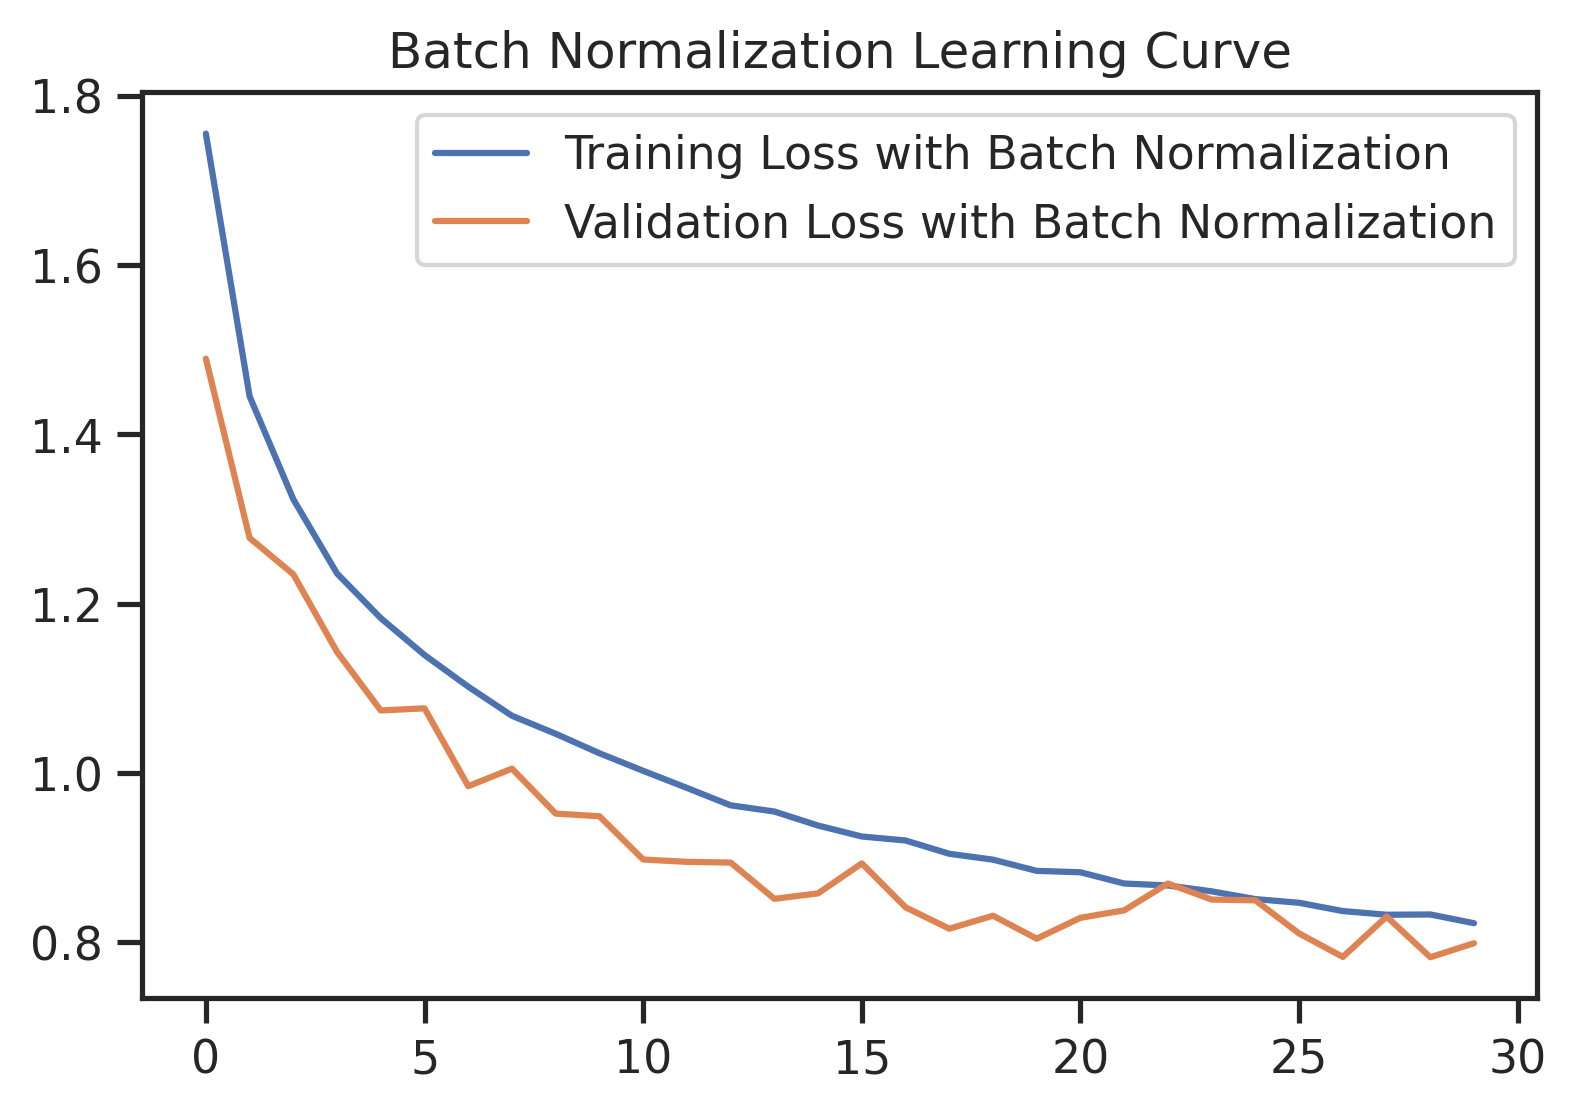

In [20]:
plt.plot(range(len(train_track)), train_track, label = "Training Loss with Batch Normalization")
plt.plot(range(len(val_track)), val_track, label = "Validation Loss with Batch Normalization")
plt.legend()
plt.title("Batch Normalization Learning Curve")
plt.show()

> By adding batch normalization after each convolution layer, we improved the best validation accuracy by 

### Does Batch Norm allow for a higher learning rate?

To test whether batch normalization allows for a higher learning rate, we try a model with a 0.5 learning rate with and without batch normalization to see if the adjustment to the model reduces loss significantly.

In [16]:
## Initiate two models, one for the simple neural network and one for batch normalization
simple_large_lr = SimpleNN()
simple_large_lr.to(device)
batch_norm_large_lr = BatchNormNN()
batch_norm_large_lr.to(device)

# Train both models
# Train simple NN 
optimizer = optim.SGD(simple_large_lr.parameters(), lr = 0.1, momentum = MOMENTUM, weight_decay = REG)
print("Training Simple NN Model with LR = 0.1 \n")
# Store the training loss and validation loss
simple_trainloss, simple_valloss = train_model(simple_large_lr, EPOCHS, CHECKPOINT_FOLDER, 0.1, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, TRACK = True)

## Train Batch Norm NN
optimizer = optim.SGD(batch_norm_large_lr.parameters(), lr = 0.1, momentum = MOMENTUM, weight_decay = REG)
print("Training Batch Normalized Model with LR = 0.1 \n")
# Store the training loss and validation loss
bn_trainloss, bn_valloss = train_model(batch_norm_large_lr, EPOCHS, CHECKPOINT_FOLDER, 0.1, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, TRACK = True)

Training Simple NN Model with LR = 0.1 

==> Optimization finished! Best validation accuracy: 0.5006
Training Batch Normalized Model with LR = 0.1 

==> Optimization finished! Best validation accuracy: 0.6669


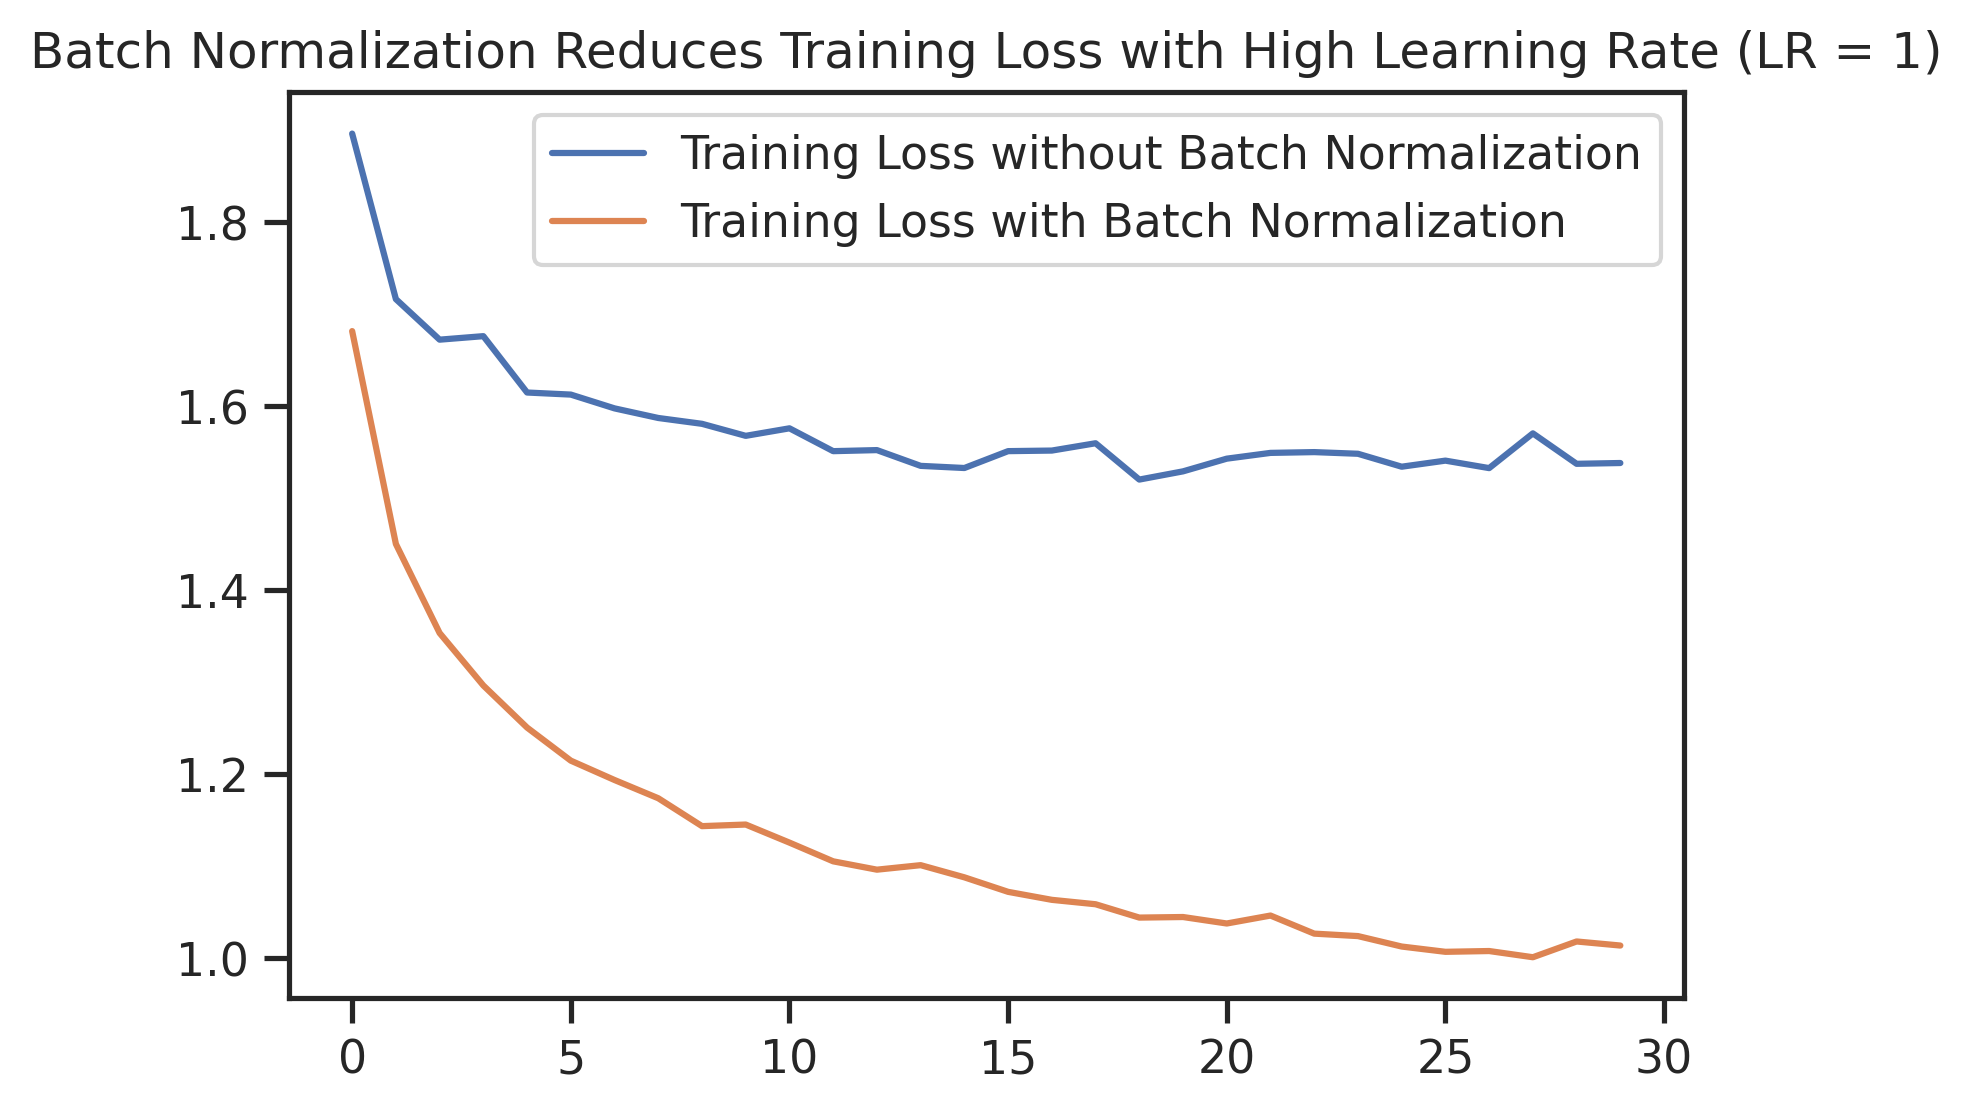

In [21]:
plt.plot(range(len(simple_trainloss)), simple_trainloss, label = "Training Loss without Batch Normalization")
plt.plot(range(len(bn_trainloss)), bn_trainloss, label = "Training Loss with Batch Normalization")
plt.legend()
plt.title("Batch Normalization Reduces Training Loss with High Learning Rate (LR = 1)")
plt.show()

### Implementing the Swish activation function

In [10]:
## Implementing the swish function
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, x):
        return torch.mul(x, torch.sigmoid(x))

In [11]:
## Creating a new model architecture and replacing ReLU with Swish
# define the Swish model;
class SwishNN(nn.Module):
    def __init__(self):
        super(SwishNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.swish1 = Swish()
        self.swish2 = Swish()
        self.swish3 = Swish()
        self.swish4 = Swish()

    def forward(self, x):
        out = self.swish1(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = self.swish2(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.swish3(self.fc1(out))
        out = self.swish4(self.fc2(out))
        out = self.fc3(out)
        return out

In [12]:
### Train the new model
# Initiate the Swish model
swish_model = SwishNN()
# Send model to GPU
swish_model.to(device)
# Set learning rate
lr = 0.1
# Set Momentum
MOMENTUM = 0.9
REG = 1e-4
# Define Criterion
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(swish_model.parameters(), lr = lr, momentum = MOMENTUM, weight_decay = REG)
# Train the model
train_track, val_track = train_model(
    swish_model, EPOCHS, CHECKPOINT_FOLDER,
    lr, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
    VERBOSE = True, TRACK = True)


==> Training starts!
Epoch 0:
Training loss: 1.6236, Training accuracy: 0.4026
Validation loss: 1.5474, Validation accuracy: 0.4614
Saving ...

Epoch 1:
Training loss: 1.3274, Training accuracy: 0.5220
Validation loss: 1.1908, Validation accuracy: 0.5625
Saving ...

Epoch 2:
Training loss: 1.2152, Training accuracy: 0.5671
Validation loss: 1.0906, Validation accuracy: 0.6002
Saving ...

Epoch 3:
Training loss: 1.1445, Training accuracy: 0.5950
Validation loss: 1.0986, Validation accuracy: 0.5920

Epoch 4:
Training loss: 1.1072, Training accuracy: 0.6066
Validation loss: 1.0192, Validation accuracy: 0.6280
Saving ...

Epoch 5:
Training loss: 1.0722, Training accuracy: 0.6164
Validation loss: 1.0501, Validation accuracy: 0.6157

Epoch 6:
Training loss: 1.0377, Training accuracy: 0.6328
Validation loss: 0.9627, Validation accuracy: 0.6508
Saving ...

Epoch 7:
Training loss: 1.0227, Training accuracy: 0.6378
Validation loss: 0.9484, Validation accuracy: 0.6529
Saving ...

Epoch 8:
Training

The Swish activation function achieved higher validation accuracy compared to the the ReLU activation function.

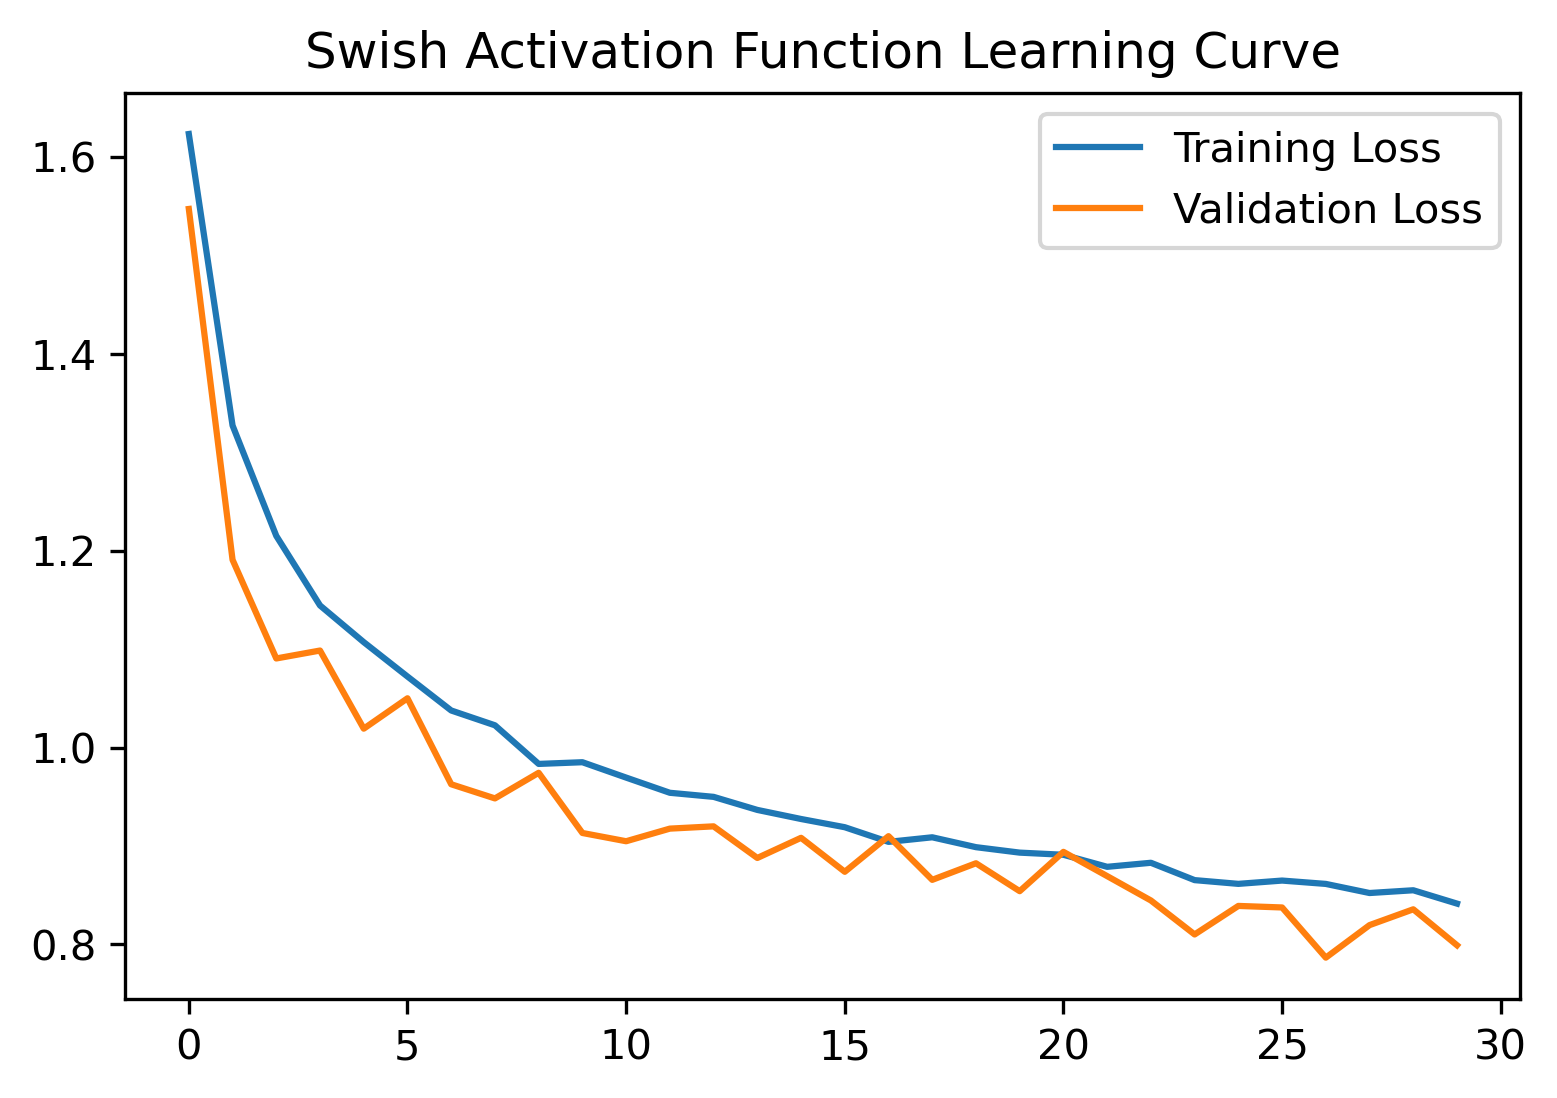

In [13]:
plt.plot(range(len(train_track)), train_track, label = "Training Loss")
plt.plot(range(len(val_track)), val_track, label = "Validation Loss")
plt.legend()
plt.title("Swish Activation Function Learning Curve")
plt.show()

### Question (c) Hyperparameter Tuning

**Part 1**

In [ ]:
### Trying a vareity of learning rate values
learning_rates = [1, 0.1, 0.05, 0.01, 0.005, 0.001]
### Create an empty array to store training losses
train_losses_lr = np.zeros([6, 30])
### Create an empty array to store validation losses
val_losses_lr = np.zeros([6, 30])

### Implement Models with each learning rate
for index, lr in enumerate(learning_rates):
    # Print current learning rate
    print(f"Training model with learning rate {lr}.")
    # Instantiate a model
    model = BatchNormNN()
    # Send model to GPU
    model.to(device)
    # Instantiate Criterion
    criterion = nn.CrossEntropyLoss()
    # Instantiate Optimizer
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = MOMENTUM, weight_decay = REG)
    # Train the model and store the loss vectors 
    train_loss_temp, val_loss_temp = train_model(model, EPOCHS, 
                                                 CHECKPOINT_FOLDER, lr, 
                                                 TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                                 TRACK = True)
    train_losses_lr[index,:] = train_loss_temp
    val_losses_lr[index,:] = val_loss_temp

Training model with learning rate 1.
==> Optimization finished! Best validation accuracy: 0.1033
Training model with learning rate 0.1.


In [ ]:
## Plot the training losses and validation losses
fig, axes = plt.subplots(1,2, figsize = (15, 7))
## Plot training losses
for index, lr in enumerate(learning_rates):
    # Plot training loss
    axes[0].plot(range(1,31), train_losses_lr[index,:], label = f"Learning Rate = {lr}")
    # Plot validation loss
    axes[1].plot(range(1,31), val_losses_lr[index,:], label = f"Learning Rate = {lr}")
    # Set labels and axis titles
    axes[0].set_title("Training Losses with Varied Learning Rates")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[1].set_title("Validation Losses with Varied Learning Rates")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
plt.show()

We see that for a really large learning rate of 1, the training losses and validation losses are not able to converge. For smaller learning rates, however, are able to perform better and find local minimas. So we can tentatively say that a large learning rate is not necessarily better for model training. The best performing learning rate is somewhere in the middle: around 0.01 - 0.005. 

In [ ]:
### Trying a vareity of regularization strengths
l2_reg = [1e-2, 1e-3, 1e-4, 1e-5, 0.0]
### Create an empty array to store training losses
train_losses = np.zeros([5, 30])
### Create an empty array to store validation losses
val_losses = np.zeros([5, 30])

### Implement Models with each learning rate
for index, reg in enumerate(l2_reg):
    # Print current learning rate
    print(f"Training model with L2 Regularization Strength of {reg}.")
    # Instantiate a model
    model = BatchNormNN()
    # Send model to GPU
    model.to(device)
    # Instantiate Criterion
    criterion = nn.CrossEntropyLoss()
    # Instantiate Optimizer
    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = MOMENTUM, weight_decay = reg)
    # Train the model and store the loss vectors 
    train_loss_temp, val_loss_temp = train_model(model, EPOCHS, 
                                                 CHECKPOINT_FOLDER, 0.01, 
                                                 TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                                 TRACK = True)
    train_losses[index,:] = train_loss_temp
    val_losses[index,:] = val_loss_temp

In [ ]:
## Plot the training losses and validation losses
fig, axes = plt.subplots(1,2, figsize = (15, 7))
## Plot training losses
for index, reg in enumerate(l2_reg):
    # Plot training loss
    axes[0].plot(range(1,31), train_losses[index,:], label = f"L2 = {reg}")
    # Plot validation loss
    axes[1].plot(range(1,31), val_losses[index,:], label = f"L2 = {reg}")
    # Set labels and axis titles
    axes[0].set_title("Training Losses with Varied L2 Regularization Strengths")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[1].set_title("Validation Losses with Varied L2 Regularization Strengths")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[0].legend()
plt.show()

We see that a L2 regularization strength of 1e-4 was able to achieve the best validation loss. The graphs of the training and validation losses agree with that assessment. However, a small regularization loss in general seems to be helpful for reducing loss and overfitting. A L2 strength of 0.01 was noticeably too large and introduced bias to the model.

### Implement L1 Regularization and Compare Weights

In [ ]:
## Define cross entropy loss function with l1 regularization
def L1CrossEntropyLoss(outputs, targets, model, lr, p):
    # Instantiate L1 loss at 0
    l1_loss = 0.0
    # Iterate over model parameters to get model L1 weights
    for param in model.parameters():
        l1_loss += torch.norm(param.data, p = p).sum()
        pass
    # Get the Cross Entropy Loss
    cel = nn.CrossEntropyLoss()
    # Ad the L1 regularization loss
    loss = cel(outputs, targets) + l1_loss * lr
    return loss

In [ ]:
for batch_idx, (inputs, targets) in enumerate(train_loader):
    # Instantiate L1 loss at 0
    l1_loss = 0.0
    # Iterate over model parameters to get model L1 weights
    for param in model.parameters():
        l1_loss += torch.abs(param.data).sum()
    # Send inputs to device
    inputs = inputs.to(device)
    targets = targets.to(device)
    # Send inputs to model
    outputs = model(inputs)
    # Calculate loss
    print(L1CrossEntropyLoss(outputs, targets, model))
    break

In [ ]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

## Set the number of epochs the decay parameter kicks in each time
DECAY_EPOCHS = 5
## Set the scaler for the decay
DECAY = 0.8

print("==> Training starts!")
print("="*50)

train_tracker_l1 = []
val_tracker_l1 = []

for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    # if i % DECAY_EPOCHS == 0 and i != 0:
    #     current_learning_rate = current_learning_rate * DECAY
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = current_learning_rate
    #     print("Current learning rate has decayed to %f" %current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    model.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = TRAIN_BATCH_SIZE
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        output = model(inputs)
        loss = L1CrossEntropyLoss(output, targets, model, 0.0001)
        train_loss += loss

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        predicted = torch.argmax(output, 1)
        correct_examples += (predicted == targets).sum().item()
        total_examples += inputs.shape[0]
        ####################################

    avg_loss = train_loss / len(train_loader)
    train_tracker_l1.append(avg_loss)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = VAL_BATCH_SIZE
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            output = model(inputs)
            val_loss = criterion(output, targets)

            # count the number of correctly predicted samples in the current batch
            predicted = torch.argmax(output, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += inputs.shape[0]
            ####################################

    avg_loss = val_loss / len(val_loader)
    val_tracker_l1.append(avg_loss)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

In [ ]:
weights_l1 = np.array([])
for param in model.parameters():
    weights_l1 = np.concatenate([weights_l1, param.cpu().detach().numpy().reshape(-1)], 0)

In [ ]:
## Train L2 Regularization Model with the same regularization strength

# Instantiate a model
model = BatchNormNN()
# Send model to GPU
model.to(device)
# Instantiate Criterion
criterion = nn.CrossEntropyLoss()
# Instantiate Optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = MOMENTUM, weight_decay = 0.0001)
# Train the model and store the loss vectors 
train_tracker_l2, val_tracker_l2 = train_model(model, EPOCHS, 
                                             CHECKPOINT_FOLDER, 0.01, 
                                             TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                             TRACK = True)

In [ ]:
# Compile the weights for the model using L2 regularization
weights_l2 = np.array([])
for param in model.parameters():
    weights_l2 = np.concatenate([weights_l2, param.cpu().detach().numpy().reshape(-1)], 0)

In [ ]:
fig, axes = plt.subplots(2,2,figsize = (15,15))
axes[0,0].plot(range(1,31), train_tracker_l1, label = "Training Loss with L1 Regularization")
axes[0,0].plot(range(1,31), train_tracker_l2, label = "Training Loss with L2 Regularization")
axes[0,0].legend()
axes[0,1].plot(range(1,31), val_tracker_l1, label = "Validation Loss with L1 Regularization")
axes[0,1].plot(range(1,31), val_tracker_l2, label = "Validation Loss with L2 Regularization")
axes[0,1].legend()
axes[1,0].hist(weights_l1, bins=100)
axes[1,0].set_xlim((-0.75, 0.75))
axes[1,1].hist(weights_l2, bins=100)
axes[1,1].set_xlim((-0.75, 0.75))
plt.show()